# Introduction to Pytorch & Neural Networks



## Learning Objectives


- Describe the difference between `Numpy` and `torch` arrays (`np.array` vs. `torch.Tensor`)
- Explain forward pass in neural networks using vector and matrix notation.
- Explain fundamental concepts of neural networks such as layers, nodes, activation functions, etc.
- Create a simple neural network in PyTorch for regression or classification

## Imports


In [ ]:
import sys
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

<br><br>

## Structure of Neural Networks

Before we start working with PyTorch's interfaces, I'd like to build up our understanding of what a neural network actually does to data. We'll see that neural networks are built up of very simple mathematical transformations, which are then stacked on top of each other to produce complex models.


In [ ]:
import numpy as np
x = np.random.rand(5)
x

array([0.7006045 , 0.6008325 , 0.34256629, 0.32753682, 0.62767726])

A single *unit* of a neural network has two stages:

1. The unit takes the entries of $x$, multiplies them by some *weights*, and adds them together, forming the linear combination $y = \sum_i w_i x_i$. This number $y$ is often called the *activation*.
2. Second, the unit hits $y$ with a non-linear function, producing a new output $z$: $z = g(y)$.

A common nonlinear function is the sigmoid (same function as used in logistic regression):

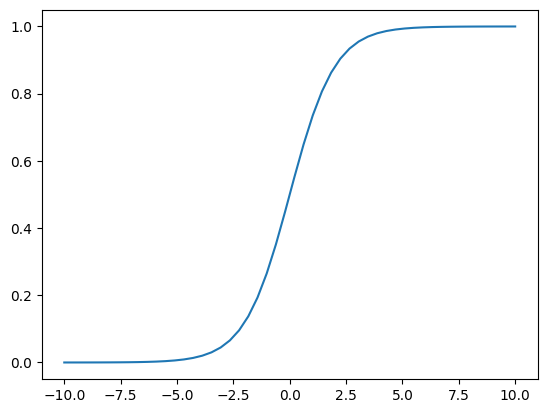

In [ ]:
from matplotlib import pyplot as plt
sigmoid = lambda x: 1 / (1 + np.exp(-x))
X = np.linspace(-10, 10)
plt.plot(X, sigmoid(X))

So, given a weight vector $w$, we can easily compute the layer output  for $x$, remembering that `w @ x` will calculate the inner product for us.

In [ ]:
w = np.random.rand(5)
z = sigmoid(w @ x)
z

0.720663978342614

In practice, we perform this computation using many data points and many units simultaneously. In this case, we can represent the data points as an $m \times n$ matrix $\mathbf{X}$, where $m$ is the number of data points and $n$ is the number of columns. We can represent the matrix of weights as an $p \times n$ matrix $\mathbf{W}$, where $p$ is the number of units in the layer. We can then compute all the activations simultaneously by computing the matrix product $\mathbf{Y} = \mathbf{W} \mathbf{X}^T$.

Here's a nice picture from the [website of Jeremy Jordan](https://www.jeremyjordan.me/intro-to-neural-networks/) to visualize what's going on. In this diagram, `a` is the activation (what I've been calling $y$).

![](https://www.jeremyjordan.me/content/images/2018/01/Screen-Shot-2017-11-07-at-12.53.07-PM.png)

We can then hit $\mathbf{Y}$ with the sigmoid function (entrywise) to form the output $\mathbf{Z}$.

In [ ]:
m = 100
n = 5
p = 10
X = np.random.rand(m, n)
W = 1/p * np.random.rand(p, n)

new_X = sigmoid(W @ X.T)

In [ ]:
new_X.shape

(10, 100)

Here's the thing: we now have a *new* matrix, that I'll call $\mathbf{X}_1$, of size $p \times m$. We can now plug that into a NEW layer, getting a new matrix $\mathbf{X}_2$. We can plug THAT into a new layer, etc. By composing all these operations, we get a single, multistage function. **This is a deep neural network.** At the end of the pipeline, we should make sure we have an output that corresponds to the task we want to perform. For example, if we want to do binary classification (classification between two categories), we our weights to look something like this:

In [ ]:
W = 1/2 * np.random.rand(2, m)
output = sigmoid(W @ new_X.T)
output.shape

(2, 10)

The dimension of size 2 holds numbers describing the model's confidence in each of the two categories. At the moment, of course, we haven't done anything like fitting our model to data, so these predictions aren't meaningful (yet).

Note that, while we don't have any control over the data $\mathbf{X}$, we are free to choose the weights $\mathbf{W}$ however we please. Traiing a neural network corresponds to the task of choosing these weights in such a way as to appropriately match the data.

Suppose I have a data point $x$, with 5 features (columns):

$$h_i^{(1)} = \phi^{(1)} \sum_j w_{ij}^{(1)}x_j + b_i^{(1)} $$

$$h_i^{(2)} = \phi^{(2)} \sum_j w_{ij}^{(2)}h_j^{(1)} + b_i^{(2)} $$

$$y_i = \sum_j w_{ij}^{(3)}h_j^{(2)} + b_i^{(3)} $$


Assume the following dimensionality

- $\mathbf{X}_{n \times d}$, i.e., each batch has $n$ examples
- $\mathbf{W}^{(l)}_{\text{hiddensize} \times \text{inputsize}}$, where hidden\_size and input\_size are of the corresponding layer

This can be written in vectorized form as:

$$\mathbf{h}^{(1)} = \phi^{(1)} (\mathbf{W}^{(1)}\mathbf{x} + \mathbf{b}^{(1)})$$
$$\mathbf{h}^{(2)} = \phi^{(2)} (\mathbf{W}^{(2)}\mathbf{h}^{(1)} + \mathbf{b}^{(2)})$$
$$\mathbf{y} = (\mathbf{W}^{(3)}\mathbf{h}^{(2)} + \mathbf{b}^{(3)})$$

And in matrix form as:

$$\mathbf{H}^{(1)} = \phi^{(1)} (\mathbf{X}\mathbf{W}^{(1)\text{T}} + \mathbf{b}^{(1)})$$
$$\mathbf{H}^{(2)} = \phi^{(2)} (\mathbf{H}^{(1)}\mathbf{W}^{(2)\text{T}} + \mathbf{b}^{(2)})$$
$$\mathbf{Y} = (\mathbf{H}^{(2)}\mathbf{W}^{(3)\text{T}} + \mathbf{b}^{(3)})$$

- Assume broadcasting is used to add the bias vector to each row of the matrix.  


<br><br>

__iClicker__: Select all of the following statements which are TRUE.

- A. In a neural network, the number of nodes in the hidden layer must always be greater than the number of input nodes.
- B. Activation functions in a neural network are used to introduce non-linearity into the network model.
- C. In regression problems, it is advisable to apply a sigmoid function to the output, similar to other nodes.
- D. The same activation function must be used for all neurons in a feedforward neural network.
- E. During the forward pass, the bias in each neuron is added to the weighted sum of inputs before applying the activation function.

## The gradient descent method


Here's the overview of common gradient descent :
- **Initialization:** Start with an initial set of parameters, often randomly chosen.
- **Forward pass:** Generate predictions using the current values of the parameters. (E.g., $\hat{y_i} = x_{1}w_1 + Bias$ in the toy example above)
- **Loss calculation:** Evaluate the loss, which quantifies the discrepancy between the model's predictions and the actual target values.
- **Gradient calculation:** Compute the gradient of the loss function with respect to each parameter either on a batch or the full dataset. This gradient indicates the direction in which the loss is increasing and its magnitude.
- **Parameter Update**: Adjust the parameters in the opposite direction of the calculated gradient, scaled by the learning rate. This step aims to reduce the loss by moving the parameters toward values that minimize it.


How can we calculate the gradient of the loss with respect to the parameters in a  complicated network?

- Feedforward to make prediction, from the input layer to output layer
- Back propagation from the output layer to input layer

What do we want from a deep learning framework?

- **Automatic Differentiation:** Essential for efficiently computing gradients

- **GPU Support:** To leverage the power of GPUs for faster computation

- **Optimization and Inspection of Computation Graph:** Tools to optimize performance and the ability to inspect or visualize the computation graph for debugging and understanding model behaviour.

There are several popular deep-learning frameworks
- [PyTorch by Facebook AI](https://pytorch.org/)
- [TensorFlow and Keras by Google](https://www.tensorflow.org/guide/keras)
- [Apache MXNet](https://mxnet.apache.org)
- [Microsoft Cognitive Toolkit (CNTK)](https://learn.microsoft.com/en-us/cognitive-toolkit/getting-started)

[Here](https://datascientest.com/en/pytorch-all-about-this-framework) and [here](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) you will find some resources discussing PyTorch vs. TensorFlow.

<br><br><br><br>

## Introduction to PyTorch

### Why PyTorch

PyTorch is a Python-based tool for scientific computing. Some pros of PyTorch are

- Python-friendly

- Good documentation and community support
- Open source
- Plenty of projects out there using PyTorch
- Dynamic graphs

In general, PyTorch does two main things:

- Provides an n-dimensional array object similar to that of `Numpy`, with the difference that it can be manipulated using GPUs

- Computes gradients (through automatic differentiation)

<br><br><br>

### PyTorch's Tensor


- In PyTorch a tensor is just like NumPy's `ndarray` that we have become so familiar with.

- A key difference between PyTorch's `torch.Tensor` and Numpy's `np.array` is that `torch.Tensor` was constructed to integrate with GPUs and PyTorch's computational graphs

### `ndarray` vs `tensor`

- Creating and working with tensors is much the same as with Numpy `ndarrays`

- You can create a tensor with `torch.tensor()` in various ways:

In [ ]:
a = torch.tensor([1, 2, 3.])

In [ ]:
b = torch.tensor([1, 2, 3])

In [ ]:
a

tensor([1., 2., 3.])

In [ ]:
b

tensor([1, 2, 3])

Let's see the datatype of each tensor:

In [ ]:
for _ in [a, b]:
    print(f"{_}, dtype: {_.dtype}")

tensor([1., 2., 3.]), dtype: torch.float32
tensor([1, 2, 3]), dtype: torch.int64


<br><br><br>

- PyTorch comes with most of the `Numpy` functions we're already familiar with:

In [ ]:
torch.zeros(2, 2)  # zeroes

tensor([[0., 0.],
        [0., 0.]])

In [ ]:
torch.ones(2, 2)  # ones

tensor([[1., 1.],
        [1., 1.]])

In [ ]:
torch.randn(3, 2)  # random normal

tensor([[-0.2775, -0.6283],
        [-0.1611, -1.0545],
        [ 0.2580, -1.6911]])

In [ ]:
torch.rand(2, 3, 2)  # rand uniform

tensor([[[0.6842, 0.3430],
         [0.9153, 0.2803],
         [0.4425, 0.9352]],

        [[0.3912, 0.5072],
         [0.0852, 0.2297],
         [0.4358, 0.5976]]])

- Just like in NumPy we can look at the shape of a tensor with the `.shape` attribute:

In [ ]:
x = torch.rand(2, 3, 2, 2)
x.shape

torch.Size([2, 3, 2, 2])

In [ ]:
x.ndim

4

<br><br><br>

### Tensors and Data Types

- Different dtypes have different memory and computational implications
- In Pytorch we'll be building networks that require thousands, millions, or even billions of floating point calculations
- In such cases, using a smaller dtype like `float32` can significantly speed up computations and reduce memory requirements
- The **default float dtype in Pytorch is `float32`**, as opposed to Numpy's `float64`
- In fact some operations in Pytorch will even throw an error if you pass a high-memory `dtype`

In [ ]:
torch.tensor([1., 2]).dtype

torch.float32

In [ ]:
print(np.array([3.14159]).dtype)
print(torch.tensor([3.14159]).dtype)

float64
torch.float32


- But just like in Numpy, you can always specify the particular dtype you want using the `dtype` argument:

In [ ]:
print(torch.tensor([3.14159], dtype=torch.float16).dtype)

torch.float16


<br><br><br>

### Operations on Tensors

- Tensors operate just like `ndarrays` and have a variety of familiar methods that can be called off them:

In [ ]:
a = torch.rand(1, 3)
b = torch.rand(3, 1)

In [ ]:
a

tensor([0.2270, 0.0756, 0.0514])

In [ ]:
b

tensor([[0.7117],
        [0.2286],
        [0.3695]])

In [ ]:
a + b  # broadcasting betweean a 1 x 3 and 3 x 1 tensor

tensor([[0.9388, 0.7873, 0.7632],
        [0.4557, 0.3042, 0.2801],
        [0.5966, 0.4451, 0.4210]])

In [ ]:
a * b  # element-wise multiplication

tensor([[0.1616, 0.0538, 0.0366],
        [0.0519, 0.0173, 0.0118],
        [0.0839, 0.0279, 0.0190]])

In [ ]:
a @ b # matrix multiplication

tensor([0.1979])

In [ ]:
a.mean()

tensor(0.1180)

In [ ]:
a.sum()

tensor(0.3541)

<br><br><br>

### Indexing

- Once again, same as Numpy

In [ ]:
X = torch.rand(5, 2)
print(X)

tensor([[0.4308, 0.2985],
        [0.9602, 0.6800],
        [0.5904, 0.1944],
        [0.5555, 0.3200],
        [0.6979, 0.3102]])


In [ ]:
print(X[0, :])
print(X[0])
print(X[:, 0])

tensor([0.4308, 0.2985])
tensor([0.4308, 0.2985])
tensor([0.4308, 0.9602, 0.5904, 0.5555, 0.6979])


<br><br><br>



### Numpy Bridge

- Sometimes we might want to convert a tensor back to a NumPy array

- We can do that using the `.Numpy()` method

In [ ]:
X = torch.rand(3,3)
print(type(X))
X_numpy = X.numpy()
print(type(X_numpy))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


<br><br><br>

### Using GPU with PyTorch

- GPU is a graphical processing unit (as opposed to a CPU: central processing unit)

- GPUs were originally developed for gaming. They are very fast at performing operations on large amounts of data by performing them in parallel (think about updating the value of all pixels on a screen very quickly as a player moves around in a game)

- More recently, GPUs have been adapted for more general purpose programming

- Neural networks can typically be broken into smaller computations that can be performed in parallel on a GPU

- PyTorch is tightly integrated with [CUDA](https://en.wikipedia.org/wiki/CUDA) (Compute Unified Device Architecture), a software layer developed by Nvidia that facilitates interactions with an Nvidia GPU (if you have one)

- You can check if you have a CUDA GPU:

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Sat Jun  8 17:42:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

- In May 2022, PyTorch also announced GPU-accelerated PyTorch training on Mac (see [here](https://pytorch.org/blog/introducing-accelerated-pytorch-training-on-mac/)) using [Apple’s Metal Performance Shaders (MPS)](https://developer.apple.com/metal/).

- If you're using a Mac equipped with **Apple silicon** (M1 or M2), you can benefit from its GPU cores to train your PyTorch models:

In [ ]:
torch.backends.mps.is_available()

False

- When training on a machine that has a GPU, you need to tell PyTorch you want to use it

- You'll see the following at the top of most PyTorch code:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda


- You can then use the `device` argument when creating tensors to specify whether you wish to use a CPU or GPU

- Or if you want to move a tensor between the CPU and GPU, you can use the `.to()` method:

In [ ]:
X = torch.rand(2, 2, 2, device=device)
X.device

device(type='cuda', index=0)

In [ ]:
X_cpu = X.to('cpu')

In [ ]:
X_cpu.device

device(type='cpu')

In [ ]:
# X.to('cuda')  # will give me an error as I don't have a CUDA GPU

<br><br><br>

#### Gradient computation

Basically, we use the process of using the chain rule in a backward manner (from the last computation back to its root at the variable), called **back-propagation**. Let's just see how we make PyTorch compute the gradient for us using back-propagation.

PyTorch provides a `.backward()` method on every tensor that takes part in gradient computation. This enables us to **do gradient descent without worrying about the structure of our model**, since we no longer need to compute the derivative ourselves.

At a high-level, the idea is that the loss function is a series of elementary computations performed on the weight parameters, along with some constant data points and biases. So if we track computations that involve the weights all the way to the loss function, we can compute the gradient of the loss function using back-propagation w.r.t to the weights.

<br><br><br>

If we now define `w` using PyTorch tensors, we can use `.backward()` on our loss function to compute the derivative w.r.t to `w`:

In [ ]:
X = torch.tensor([1.0, 2.0, 3.0], requires_grad=False)
w = torch.tensor([1.0], requires_grad=True)  # Random initial weight
y = torch.tensor([2.0, 4.0, 6.0], requires_grad=False)  # Target values
mse = ((X * w - y)**2).mean()
mse.backward()
# w.grad

In [ ]:
w.grad

tensor([-9.3333])

In [ ]:
y.grad

tensor([0.6667, 1.3333, 2.0000])

In [ ]:
X@(X*w - y) * (2/3)

tensor(-9.3333, grad_fn=<MulBackward0>)

<br><br><br>

<br><br><br>

### Simple Linear Regression with PyTorch

- Let's create a simple regression dataset with 500 observations:

In [ ]:
X, y = make_regression(n_samples=500, n_features=1, random_state=0, noise=10.0)

In [ ]:
import matplotlib.pyplot as plt

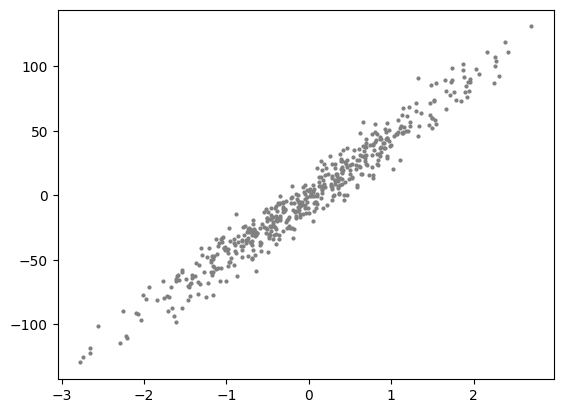

In [ ]:
plt.scatter(X, y, color = "grey", s = 4, zorder = 100)

- We know how to fit a simple linear regression to this data using sklearn:

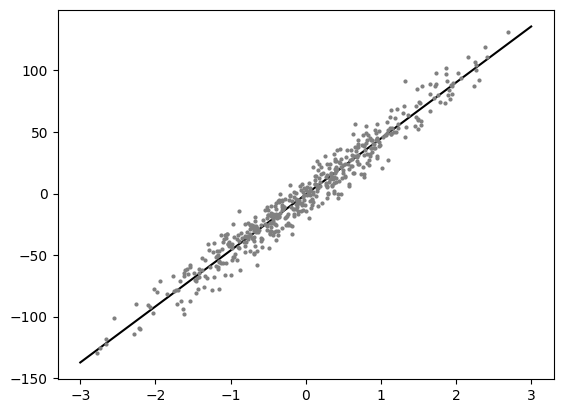

In [ ]:
sk_model = LinearRegression().fit(X, y)
x_space = np.linspace(-3, 3, 101)
plt.scatter(X, y, color = "grey", s = 4, zorder = 100)
plt.plot(x_space, sk_model.intercept_ + x_space * sk_model.coef_[0], color = "black")

- Here are the parameters of that fitted line:

In [ ]:
print(f"w_0: {sk_model.intercept_:.2f} (bias/intercept)")
print(f"w_1: {sk_model.coef_[0]:.2f}")

w_0: -0.77 (bias/intercept)
w_1: 45.50


- As an equation, that looks like this:

$$\hat{y}=-0.77 + 45.50x$$

- Or in matrix form:

$$\begin{bmatrix} \hat{y_1} \\ \hat{y_2} \\ \vdots \\ \hat{y_n} \end{bmatrix}=\begin{bmatrix} 1 & x_{11} \\ 1 & x_{21} \\ \vdots & \vdots \\ 1 & x_{n1} \end{bmatrix} \begin{bmatrix} -0.77 \\ 45.55 \end{bmatrix}$$

- Or in graph form, as we have seen above.



<br><br><br>

### Linear Regression with a Neural Network in PyTorch

- So let's implement the above in PyTorch to start gaining an intuition about neural networks

- Every neural network model you build in PyTorch has to inherit from `torch.nn.Module`

- Remember inheritance allows us to inherit commonly needed functionality without having to write code ourselves

- Think about sklearn models: they all inherit common methods like `.fit()`, `.predict()`, `.score()`, etc. When creating a neural network, we define our own architecture but still want common functionality which we inherit from `torch.nn.Module`.

- Let's create a model called `linearRegression` and then I'll talk you through the syntax:

In [ ]:
class linearRegression(nn.Module):  # our class inherits from nn.Module and we can call it anything we like

    def __init__(self, input_size, output_size):
        super().__init__()  # super().__init__() makes our class inherit everything from torch.nn.Module

        self.linear = nn.Linear(input_size, output_size, device=device)  # this is a simple linear layer: wX + b

    def forward(self, x):
        out = self.linear(x)
        return out

Let's step through the above:

```python
class linearRegression(nn.Module):
    
    def __init__(self, input_size, output_size):
        super().__init__()
```

<br><br><br>

Here we're creating a class called `linearRegression` and inheriting the methods and attributes of `nn.Module`

(hint: try typing `help(linearRegression)` to see all the things we inherited from `nn.Module`).

```python
        self.linear = nn.Linear(input_size, output_size)
```

<br><br><br>

Here we're defining a "Linear" layer, which just means `wX + b`, i.e., the weights of the network, multiplied by the inputs plus the bias.

```python
    def forward(self, x):
        out = self.linear(x)
        return out
```

PyTorch networks created with `nn.Module` must have a `forward()` method. It accepts the input data `x` and passes it through the defined operations. In this case, we are passing `x` into our linear layer and getting an output `out`.

<br><br><br>

- After defining the model class, we can create an instance of that class:

In [ ]:
model = linearRegression(input_size=1, output_size=1)

- We can check out our model using `print()`:

In [ ]:
print(model)

linearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


- Or the more useful `summary()` (which we imported at the top of this notebook with `from torchsummary import summary`):

In [ ]:
summary(model, (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Notice how we have two parameters? We have one for the weight (`w1`) and one for the bias (`w0`)

- These were initialized **randomly** by PyTorch when we created our model. They can be accessed with `model.state_dict()`:

In [ ]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.8234]], device='cuda:0')),
             ('linear.bias', tensor([-0.2174], device='cuda:0'))])

<br><br><br>

- Our `X` and `y` data are currently Numpy arrays but they need to be PyTorch tensors

- Let's convert them:

In [ ]:
X_t = torch.tensor(X, dtype=torch.float32, device=device)
y_t = torch.tensor(y, dtype=torch.float32, device=device)

In [ ]:
y_t.shape

torch.Size([500])

<br><br><br>

- We have a working model right now and could tell it to give us some output with this syntax:

In [ ]:
model(X_t[0:10])

tensor([[ 0.2934],
        [-0.2087],
        [-0.1400],
        [-1.5974],
        [ 1.0017],
        [-0.0262],
        [-0.9656],
        [ 0.0705],
        [ 0.0617],
        [-0.5445]], device='cuda:0', grad_fn=<AddmmBackward0>)

That's just a raw prediction, and far from the actual value of:

In [ ]:
y_t[0:10]

tensor([ 31.0760,  -0.8635,  -0.7614, -70.8545,  85.1721,  16.6973, -53.7972,
          5.9187,  16.6105, -38.0474], device='cuda:0')

It's because our model is not trained yet.

What does training mean? In the context of what we've learned so far, it means that we haven't yet done an SGD run to find optimal weights.


    1. **a loss function** (called "`criterion`" in PyTorch) to tell us how good/bad our predictions are. We'll use mean squared error, `torch.nn.MSELoss()`. See the list of different loss functions in PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions).
    
    2. **an optimization algorithm** to help optimize model parameters. We'll use SGD, `torch.optim.SGD()`. See the list of different optimization algorithms in PyTorch [here](https://pytorch.org/docs/stable/optim.html#module-torch.optim).

In [ ]:
LEARNING_RATE = 0.02
criterion = nn.MSELoss()  # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  # optimization algorithm is SGD

- Before we train I'm going to create a **data loader** to help batch my data

- We'll use a `BATCH_SIZE=50` (which should give us 10 batches because we have 500 data points)

In [ ]:
BATCH_SIZE = 50
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader

- We should have 10 batches:

In [ ]:
len(dataloader)

10

- We can look at a batch using this syntax:

In [ ]:
XX, yy = next(iter(dataloader))

In [ ]:
print(f"Shape of feature data (X) in batch: {XX.shape}")
print(f"Shape of response data (y) in batch: {yy.shape}")

Shape of feature data (X) in batch: torch.Size([50, 1])
Shape of response data (y) in batch: torch.Size([50])


<br><br><br>

Let's write code for doing a typical SGD with 10 epochs, but using automatic differentiation of PyTorch:

In [ ]:
def trainer(model, criterion, optimizer, dataloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""

    for epoch in range(epochs):
        losses = 0

        for X, y in dataloader:

            optimizer.zero_grad()       # Clear gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss
            loss.backward()             # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            losses += loss.item()       # Add loss for this batch to running total

        if verbose: print(f"epoch: {epoch + 1}, loss: {losses / len(dataloader):.4f}")

<br><br><br>

OK, before starting the training, here are the model parameters before training for reference:

In [ ]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.8234]], device='cuda:0')),
             ('linear.bias', tensor([-0.2174], device='cuda:0'))])

<br><br><br>

In [ ]:
trainer(model, criterion, optimizer, dataloader, epochs=30, verbose=True)

epoch: 1, loss: 1514.1319
epoch: 2, loss: 722.4701
epoch: 3, loss: 372.4155
epoch: 4, loss: 216.6695
epoch: 5, loss: 147.7141
epoch: 6, loss: 117.3435
epoch: 7, loss: 104.1280
epoch: 8, loss: 98.1286
epoch: 9, loss: 95.4571
epoch: 10, loss: 94.2249
epoch: 11, loss: 93.6763
epoch: 12, loss: 93.3265
epoch: 13, loss: 93.2907
epoch: 14, loss: 93.2532
epoch: 15, loss: 93.2504
epoch: 16, loss: 93.2423
epoch: 17, loss: 93.1943
epoch: 18, loss: 93.1826
epoch: 19, loss: 93.2637
epoch: 20, loss: 93.2786
epoch: 21, loss: 93.2031
epoch: 22, loss: 93.2276
epoch: 23, loss: 93.2349
epoch: 24, loss: 93.2376
epoch: 25, loss: 93.2530
epoch: 26, loss: 93.1830
epoch: 27, loss: 93.2000
epoch: 28, loss: 93.2703
epoch: 29, loss: 93.1961
epoch: 30, loss: 93.2142


<br><br><br>

- Now our model has been trained, our parameters should be different than before:

In [ ]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[45.5019]], device='cuda:0')),
             ('linear.bias', tensor([-0.7741], device='cuda:0'))])

- Comparing to our sklearn model, we get the same answer:

In [ ]:
pd.DataFrame({"w0": [sk_model.intercept_, model.state_dict()['linear.bias'].item()],
              "w1": [sk_model.coef_[0], model.state_dict()['linear.weight'].item()]},
             index=['sklearn', 'pytorch']).round(2)

,w0,w1
sklearn,-0.77,45.5
pytorch,-0.77,45.5


- We got pretty close

- We could do better by changing the number of epochs or the learning rate
- So here is our simple network once again:


- By the way, check out what happens if we run `trainer()` again:

In [ ]:
trainer(model, criterion, optimizer, dataloader, epochs=20, verbose=True)

epoch: 1, loss: 93.3071
epoch: 2, loss: 93.2027
epoch: 3, loss: 93.2832
epoch: 4, loss: 93.1712
epoch: 5, loss: 93.3651
epoch: 6, loss: 93.2526
epoch: 7, loss: 93.2466
epoch: 8, loss: 93.2170
epoch: 9, loss: 93.2391
epoch: 10, loss: 93.2662
epoch: 11, loss: 93.1802
epoch: 12, loss: 93.2788
epoch: 13, loss: 93.2378
epoch: 14, loss: 93.2437
epoch: 15, loss: 93.1980
epoch: 16, loss: 93.2742
epoch: 17, loss: 93.2069
epoch: 18, loss: 93.2352
epoch: 19, loss: 93.2256
epoch: 20, loss: 93.2527


- **Our model continues where we left off**

- This may or may not be what you want. We can start from scratch by re-making the `model` and `optimizer`.

In [ ]:
pd.DataFrame({"w0": [sk_model.intercept_, model.state_dict()['linear.bias'].item()],
              "w1": [sk_model.coef_[0], model.state_dict()['linear.weight'].item()]},
             index=['sklearn', 'pytorch']).round(2)

,w0,w1
sklearn,-0.77,45.50
pytorch,-0.76,45.49


<br><br><br>

### Multiple Linear Regression with a Neural Network

- Okay, let's do a multiple linear regression now with 3 features


<br><br><br>

- Let's go ahead and create some data:

In [ ]:
# Create dataset
X, y = make_regression(n_samples=500, n_features=3, random_state=0, noise=10.0)
X_t = torch.tensor(X, dtype=torch.float32, device=device)
y_t = torch.tensor(y, dtype=torch.float32, device=device)

# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

- And let's create the above model:

In [ ]:
y_t.shape

torch.Size([500])

In [ ]:
model = linearRegression(input_size=3, output_size=1)

- We should now have 4 parameters (3 weights and 1 bias)

In [ ]:
summary(model, (3,));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               4
Total params: 4
Trainable params: 4
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Looks good to me! Let's train the model and then compare it to sklearn's `LinearRegression()`:

In [ ]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.5593,  0.0668,  0.3191]], device='cuda:0')),
             ('linear.bias', tensor([0.5686], device='cuda:0'))])

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
trainer(model, criterion, optimizer, dataloader, epochs=100, verbose=False)

In [ ]:
sk_model = LinearRegression().fit(X, y)
pd.DataFrame({"w0": [sk_model.intercept_, model.state_dict()['linear.bias'].item()],
              "w1": [sk_model.coef_[0], model.state_dict()['linear.weight'][0, 0].item()],
              "w2": [sk_model.coef_[1], model.state_dict()['linear.weight'][0, 1].item()],
              "w3": [sk_model.coef_[2], model.state_dict()['linear.weight'][0, 2].item()]},
             index=['sklearn', 'pytorch']).round(2)

,w0,w1,w2,w3
sklearn,0.43,0.62,55.99,11.14
pytorch,0.57,0.60,55.95,11.24


<br><br><br>

### Non-linear Regression with a Neural Network

- Okay so we can make a simple network to imitate simple and multiple *linear* regression

- For example, what happens when we have more complicated datasets like this?

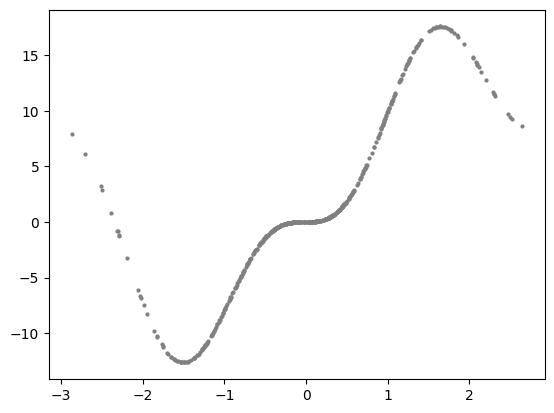

In [ ]:
# Create dataset
np.random.seed(2020)

X = np.sort(np.random.randn(500))
y = X ** 2 + 15 * np.sin(X) **3

X_t = torch.tensor(X[:, None], dtype=torch.float32, device=device)
y_t = torch.tensor(y, dtype=torch.float32, device=device)

# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

plt.scatter(X, y, color = "grey", s = 4, zorder = 100)

- This is obviously non-linear, and we need to introduce some **non-linearities** into our network

- These non-linearities are what make neural networks so powerful and they are called **"activation functions"**
- We are going to create a new model class that includes a non-linearity, that is, a sigmoid function:

$$S(x)=\frac{1}{1+e^{-x}}$$

- We'll talk more about activation functions later, but note how the sigmoid function non-linearly maps `x` to a value between 0 and 1

- Okay, so let's create the following network:

In [ ]:
X_t.shape

torch.Size([500, 1])

- All this means is that the value of each node in the hidden layer will be transformed by the "activation function", thus introducing non-linear elements to our model

- There's **two main ways** of creating the above model in PyTorch, I'll show you both:

In [ ]:
class nonlinRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden = nn.Linear(input_size, hidden_size, device=device)
        self.output = nn.Linear(hidden_size, output_size, device=device)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)       # input -> hidden layer
        x = self.sigmoid(x)      # sigmoid activation function in hidden layer
        x = self.output(x)       # hidden -> output layer
        return x

- Note how our `forward()` method now passes `x` through the `nn.Sigmoid()` function after the hidden layer

- The above method is very clear and flexible, but I prefer using `nn.Sequential()` to combine my layers together in the constructor:

In [ ]:
class nonlinRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.main = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size, device=device),  # input -> hidden layer
            nn.Sigmoid(),                        # sigmoid activation function in hidden layer
            nn.Linear(hidden_size, output_size, device=device)  # hidden -> output layer
        )

    def forward(self, x):
        x = self.main(x)
        return x

- Let's make an instance of our new class and confirm it has 10 parameters (6 weights + 4 biases):

In [ ]:
model = nonlinRegression(1, 3, 1)
summary(model, (1,));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               6
           Sigmoid-2                    [-1, 3]               0
            Linear-3                    [-1, 1]               4
Total params: 10
Trainable params: 10
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Okay, let's train:

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

trainer(model, criterion, optimizer, dataloader, epochs=1000, verbose=False)

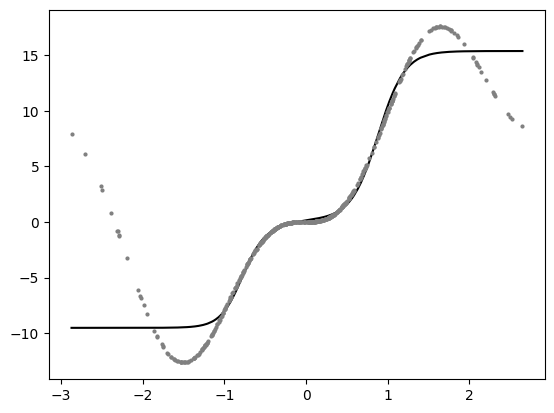

In [ ]:
y_p = model(X_t).detach().cpu().numpy().squeeze()
plt.scatter(X, y, color = "grey", s = 4, zorder = 100)
plt.plot(X, y_p, color = "black")

- Take a look at those non-linear predictions

- Our model is not great and we could make it better soon by adjusting the learning rate, the number of nodes, and the number of epochs


### Deep Learning

You've probably heard the magic term **"deep learning"** and you're about to find out what it means

- **Deep neural network: a neural network with more than 1 hidden layer**

- On the other hand, a neural network with only 1 hidden layer is called a **shallow neural network**.

I like to think of each layer as a "feature engineer", it is trying to extract information from the layer before it

<br><br><br>

- Let's create a "deep" network of 2 layers:


In [ ]:
class deepRegression(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_size_1, device=device),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2, device=device),
            nn.Sigmoid(),
            nn.Linear(hidden_size_2, output_size, device=device)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
model = deepRegression(1, 5, 3, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)

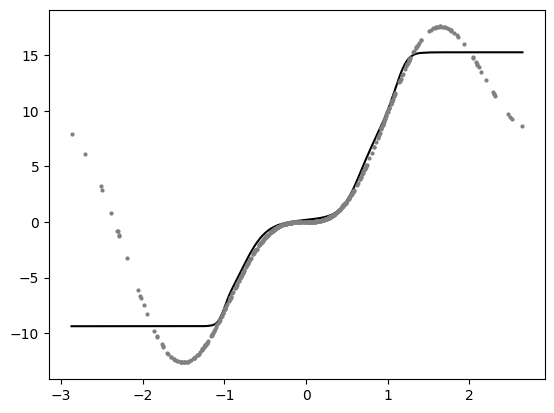

In [ ]:
trainer(model, criterion, optimizer, dataloader, epochs=10**3, verbose=False)
plt.scatter(X, y, color = "grey", s = 4, zorder = 100)
plt.plot(X, model(X_t).detach().cpu(), color = "black")


The neural network is doing a good job, but it's still struggling to handle data points near the boundaries, but we can do better by having more neurons in our network:

In [ ]:
model = deepRegression(1, 10, 10, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

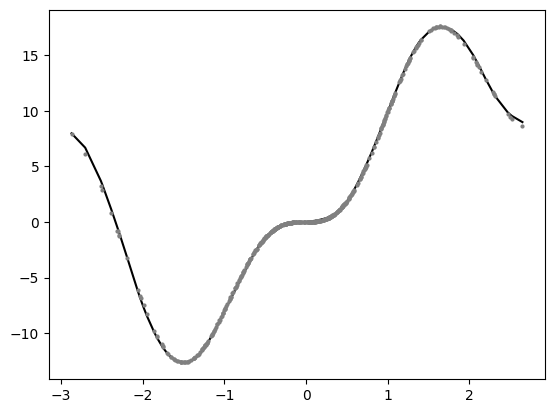

In [ ]:
trainer(model, criterion, optimizer, dataloader, epochs=10**3, verbose=False)
plt.scatter(X, y, color = "grey", s = 4, zorder = 100)
plt.plot(X_t.cpu(), model(X_t).detach().cpu(), color = "black")

## Activation Functions


- Activation functions are what allow us to model complex, non-linear functions

- There are **many** different activations functions:

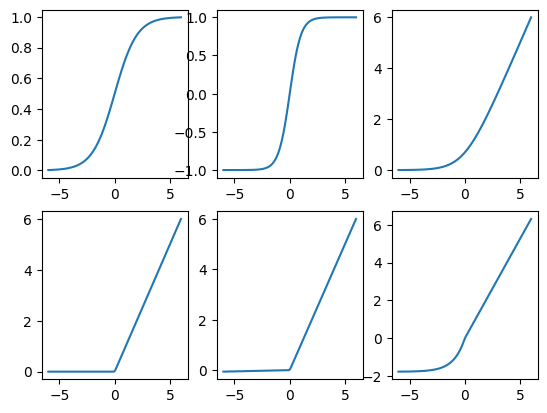

In [ ]:
functions = [torch.nn.Sigmoid, torch.nn.Tanh, torch.nn.Softplus, torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.SELU]

fig, ax = plt.subplots(2,3 )

for (i,f) in enumerate(functions):
  ax.reshape(-1)[i].plot(torch.linspace(-6, 6, 100), f()(torch.linspace(-6, 6, 100)))

- Activation functions should be non-linear and tend to be monotonic and continuously differentiable (smooth)

- But as you can see with the ReLU function above, that's not always the case

- I wanted to point this out because it highlights how much of an art deep learning really is.
- Here's a great quote from [Yoshua Bengio](https://en.wikipedia.org/wiki/Yoshua_Bengio) (famous for his work in AI and deep learning) on his group experimenting with ReLU:

>"_...one of the biggest mistakes I made was to think, like everyone else in the 90s, that you needed smooth non-linearities in order for backpropagation to work. I thought that if we had something like rectifying non-linearities, where you have a flat part, it would be really hard to train, because the derivative would be zero in so many places. And when we started experimenting with ReLU, with deep nets around 2010, I was obsessed with the idea that, we should be careful about whether neurons won't saturate too much on the zero part. **But in the end, it turned out that, actually, the ReLU was working a lot better than the sigmoids and tanh, and that was a big surprise**...it turned out to work better, whereas I thought it would be harder to train!_"

- Anyway, TL;DR **ReLU is probably the most popular these days for training deep neural nets**, but you can treat activation functions as hyper-parameters to be optimized

<br><br><br>

## Summary


1. PyTorch is a neural network package that implements tensors with computation history

2. Neural Networks are simply:

    - Composed of an input layer, 1 or more hidden layers, and an output layer, each with 1 or more nodes.

    - The number of nodes in the Input/Output layers is defined by the problem/data. Hidden layers can have an arbitrary number of nodes.

    - Activation functions in the hidden layers help us model non-linear data.

    - Feed-forward neural networks are just a combination of simple linear and non-linear operations.
    
3. Activation functions allow the network to learn non-linear function

Based on: Varada Kolhatkar's lecture note for Supervised Learning II course, from University of British Columbia https://ubc-mds.github.io/DSCI_572_sup-learn-2/README.html